# Employee Attrition

In this notebook, various models for predicting churning employees using Employee Attrition dataset were built. As a different approach from the other implementations, both sequential and non-sequential models were built with their ensemble models. Besides, the evaluation metrics for the minor class are calculated to be able to see if the models are successful or they just favor the major class (which commonly occurs with imbalanced datasets). The parameters for the models were determined via grid search. Apart from that, the k-fold cross-validation is applied for estimating the performance of the models.

The sequential models : LSTM, GRU, Sequential Ensemble

The non-sequential models : Decision Tree, Random Forest, K-Nearest Neighbors, Support Vector Classifier, Logistic Regression, Multilayer Perceptron, Non-Sequential Ensemble

According to the results, Random Forest is the most successful one after the Non-Sequential Ensemble model when considering both classes. Due to the small amount of data, sequential models are not the best ones. The dataset does not have many features, but the approach can be used as preliminary work for more complicated employee churn models.

* [Import Libraries](#1-import-libraries)
* [Data Exploration](#2-data-exploration)
* [Data Processing](#3-data-processing)
    * [Clustering Cities by Population](#3-1-clustring-cities)
    * [Clustering Job Titles](#3-2-clusterng-jobs)
    * [Preparing Dataset for Modelling](#3-3-preparing-dataset)
        * [Dummy Variable & Categorical Variable Encoding](#3-3-1-dummy-variable)
        * [For Non Sequential Models](#3-3-2-nonseq-prepare)
            * [Removing Duplicated Employees](#3-3-2-1-remove-duplicateds)
            * [Dropping Unnecassary Features](#3-3-2-2-drop-unnec)
        * [For Sequential Models](#3-3-3-seq-prepare)
* [Modelling & Evaluation](#4-modelling-and-evaluation)
    * [Non Sequential Models](#4-1-nonseq-models)
        * [Decision Tree](#4-1-1-dt)
        * [Logistic Regression](#4-1-2-lr)
        * [KNN](#4-1-3-knn)
        * [SVC](#4-1-4-svc)
        * [Random Forest](#4-1-5-rf)
        * [Neural Network](#4-1-6-nn)
        * [Ensemble Model](#4-1-7-ensemble)
        * [Evaluation](#4-1-8-eva)
    * [Sequential Models](#4-2-seq)
        * [Creating Sequential Data Structure](#4-2-1-seq-data)
        * [LSTM](#4-2-2-lstm)
        * [GRU](#4-2-3-gru)
        * [Ensemble Model](#4-2-4-ensemble)
        * [Evaluation](#4-2-5-evaluation)

<a id="1-import-libraries"></a>
## Import Libraries

In [54]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil import parser

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.callbacks import EarlyStopping
from keras.layers import Activation

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix as cm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold 
from statistics import mean

from mlxtend.frequent_patterns import apriori, association_rules 

import warnings
warnings.filterwarnings("ignore")

<a id="2-data-exploration"></a>
## Data Exploration

In [55]:
# Loads data
dataset = pd.read_csv('https://raw.githubusercontent.com/teuschb/hr_data/master/datasets/MFG10YearTerminationData.csv')

In [56]:
# Checks size of dataset
dataset.shape

(49653, 18)

In [57]:
# Checks 18 columns names and types 
dataset.dtypes

EmployeeID              int64
recorddate_key         object
birthdate_key          object
orighiredate_key       object
terminationdate_key    object
age                     int64
length_of_service       int64
city_name              object
department_name        object
job_title              object
store_name              int64
gender_short           object
gender_full            object
termreason_desc        object
termtype_desc          object
STATUS_YEAR             int64
STATUS                 object
BUSINESS_UNIT          object
dtype: object

In [58]:
# Checks categorical values
categoricalValues = dataset.drop(["recorddate_key", "birthdate_key", "orighiredate_key", "terminationdate_key"], axis=1).select_dtypes(include=['object'])

for col in categoricalValues:
    print("Column Name: " + col + "\nValues =>")
    print(categoricalValues[col].unique())
    print("\n")

Column Name: city_name
Values =>
['Vancouver' 'Terrace' 'Nanaimo' 'Nelson' 'Kelowna' 'Victoria' 'Kamloops'
 'Fort St John' 'Surrey' 'Vernon' 'Quesnel' 'Chilliwack' 'Dawson Creek'
 'Squamish' 'New Westminster' 'Port Coquitlam' 'Cortes Island' 'Burnaby'
 'Bella Bella' 'Cranbrook' 'Williams Lake' 'Trail' 'Prince George'
 'Richmond' 'Grand Forks' 'West Vancouver' 'Abbotsford' 'Aldergrove'
 'Langley' 'North Vancouver' 'White Rock' 'New Westminister' 'Fort Nelson'
 'Haney' 'Valemount' 'Ocean Falls' 'Princeton' 'Dease Lake' 'Pitt Meadows'
 'Blue River']


Column Name: department_name
Values =>
['Executive' 'Store Management' 'Meats' 'Recruitment' 'Training'
 'Labor Relations' 'HR Technology' 'Employee Records' 'Compensation'
 'Legal' 'Produce' 'Accounts Receiveable' 'Bakery'
 'Information Technology' 'Accounts Payable' 'Audit' 'Accounting'
 'Investment' 'Dairy' 'Processed Foods' 'Customer Service']


Column Name: job_title
Values =>
['CEO' 'VP Stores' 'Legal Counsel' 'VP Human Resources' 'VP 

In [59]:
# First 5 rows of dataset
dataset.head(5)

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE


In [60]:
# Checks records for Employee #1318
dataset.loc[dataset['EmployeeID'] == 1318]

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE
5,1318,12/31/2011 0:00,1/3/1954,8/28/1989,1/1/1900,57,22,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2011,ACTIVE,HEADOFFICE
6,1318,12/31/2012 0:00,1/3/1954,8/28/1989,1/1/1900,58,23,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2012,ACTIVE,HEADOFFICE
7,1318,12/31/2013 0:00,1/3/1954,8/28/1989,1/1/1900,59,24,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2013,ACTIVE,HEADOFFICE
8,1318,12/31/2014 0:00,1/3/1954,8/28/1989,1/1/1900,60,25,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE
9,1318,12/31/2015 0:00,1/3/1954,8/28/1989,1/1/1900,61,26,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE


<a id="3-data-processing"></a>
## Data Processing

In [61]:
# Lists if any changes on ['city_name','department_name','job_title','BUSINESS_UNIT'] for all duplicated EmployeeIDs
newDataset = dataset[['EmployeeID', 'city_name', 'department_name', 'job_title', 'BUSINESS_UNIT']]
newDataset = newDataset[newDataset.duplicated('EmployeeID', keep=False)]
duplicateds = newDataset[newDataset.duplicated(keep='last')]

merged = pd.merge(newDataset,duplicateds, how='outer', indicator=True)
merged.loc[merged._merge == 'left_only', ['EmployeeID']]


,EmployeeID


We saw there is no changes on above columns for same employee. So we going to remove duplicated ones in section [Removing Duplicated Employees](#remove_duplicated) for non sequential models

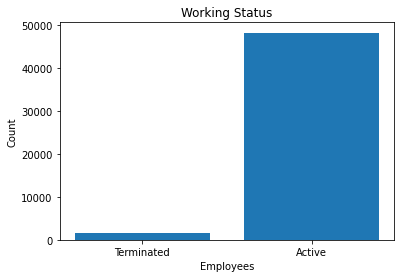

Terminated:  1485
Active:  48168


In [62]:
# Checks Active and Terminated columns because we keep last ones
statusTerminatedCount = len(dataset[dataset.STATUS == "TERMINATED"])
statusActiveCount = len(dataset[dataset.STATUS == "ACTIVE"])

plt.bar(["Terminated", "Active"],[statusTerminatedCount, statusActiveCount])
plt.xlabel("Employees")
plt.ylabel("Count")
plt.title("Working Status")
plt.show()
print("Terminated: ", statusTerminatedCount)
print("Active: ", statusActiveCount)


<a id="3-1-clustring-cities"></a>
### Clustering Cities by Population

In [63]:
# Makes cities dummy with their population
city_pop_2020 = {'Vancouver':2313328,
                 'Victoria':289625,
                 'Nanaimo':84905,
                 'New Westminster':58549,
                 'Kelowna':125109,
                 'Burnaby':202799,
                 'Kamloops':68714,
                 'Prince George':65558,
                 'Cranbrook':18610,
                 'Surrey':394976,
                 'Richmond':182000,
                 'Terrace':19443,
                 'Chilliwack':77000,
                 'Trail':9707,
                 'Langley':23606,
                 'Vernon':47274,
                 'Squamish':19512,
                 'Quesnel':13799,
                 'Abbotsford':151683,
                 'North Vancouver':48000,
                 'Fort St John':17402,
                 'Williams Lake':14168,
                 'West Vancouver':42694,
                 'Port Coquitlam':114565,
                 'Aldergrove':12363,
                 'Fort Nelson':3561,
                 'Nelson':9813,
                 'New Westminister':58549,
                 'Grand Forks':4049,
                 'White Rock':66450,
                 'Haney':82256,
                 'Princeton':2828,
                 'Dawson Creek':10802,
                 'Bella Bella':1019,
                 'Ocean Falls':129,
                 'Pitt Meadows':174410,
                 'Cortes Island':1042,
                 'Valemount':1021,
                 'Dease Lake':335,
                 'Blue River':157}
#Make a copy of city names
dataset['Pop'] = dataset['city_name']

# Map from city name to population
dataset['Pop'] = dataset.Pop.map(city_pop_2020)

# Make a new column for population category
dataset['Pop_category'] = dataset.Pop

# Categorise according to population size
# >= 100,000 is City
# 10,000 to 99,999 is Rural
# < 10,000 is Remote
# Data is taken from https://worldpopulationreview.com/countries/cities/canada
city_ix = (dataset['Pop'] >= 100000)
rural_ix = ((dataset['Pop'] < 100000) & (dataset['Pop'] >= 10000))
remote_ix = (dataset['Pop'] < 10000)
dataset.loc[city_ix, 'Pop_category'] = 'City'
dataset.loc[rural_ix, 'Pop_category'] = 'Rural'
dataset.loc[remote_ix, 'Pop_category'] = 'Remote'

dataset['Pop_category'] = dataset['Pop_category'].map({'City' : 0, 'Rural' : 1, 'Remote' : 2})

<a id="3-2-clusterng-jobs"></a>
### Clustering Job Titles

In [64]:
# Clusters job title
board = ['VP Stores', 'Director, Recruitment', 'VP Human Resources', 'VP Finance',
         'Director, Accounts Receivable', 'Director, Accounting',
         'Director, Employee Records', 'Director, Accounts Payable',
         'Director, HR Technology', 'Director, Investments',
         'Director, Labor Relations', 'Director, Audit', 'Director, Training',
         'Director, Compensation']

executive = ['Exec Assistant, Finance', 'Exec Assistant, Legal Counsel',
             'CHief Information Officer', 'CEO', 'Exec Assistant, Human Resources',
             'Exec Assistant, VP Stores']

manager = ['Customer Service Manager', 'Processed Foods Manager', 'Meats Manager',
           'Bakery Manager', 'Produce Manager', 'Store Manager', 'Trainer', 'Dairy Manager']


employee = ['Meat Cutter', 'Dairy Person', 'Produce Clerk', 'Baker', 'Cashier',
            'Shelf Stocker', 'Recruiter', 'HRIS Analyst', 'Accounting Clerk',
            'Benefits Admin', 'Labor Relations Analyst', 'Accounts Receiveable Clerk',
            'Accounts Payable Clerk', 'Auditor', 'Compensation Analyst',
            'Investment Analyst', 'Systems Analyst', 'Corporate Lawyer', 'Legal Counsel']

def changeTitle(row):
    if row in board:
        return 'board'
    elif row in executive:
        return 'executive'
    elif row in manager:
        return 'manager'
    else:
        return 'employee'
    
dataset['job_title'] = dataset['job_title'].apply(changeTitle)

<a id="3-3-preparing-dataset"></a>
### Preparing Dataset for Modelling

<a id="3-3-1-dummy-variable"></a>
#### Dummy Variable & Categorical Variable Encoding

In [65]:
# Makes all values useful for modelling
dataset = pd.get_dummies(dataset,columns=['job_title'])
dataset['gender'] = dataset['gender_short'].replace({'F':1, 'M':0})
dataset['status'] = dataset['STATUS'].replace({'ACTIVE':1, 'TERMINATED':0})
dataset['BUSINESS_UNIT'] = dataset['BUSINESS_UNIT'].replace({'STORES':1, 'HEADOFFICE':0})

<a id="3-3-2-nonseq-prepare"></a>
#### For Non Sequential Models

<a id="3-3-2-1-remove-duplicateds"></a>
##### Removing Duplicated Employees

In [66]:
# Makes all employees unique because there is no change on categoric columns
# Keeps last records

nonSequentialData = dataset.sort_values(['EmployeeID', 'length_of_service'], ascending=[True, True]).drop_duplicates('EmployeeID', keep='last').reset_index(drop=True)

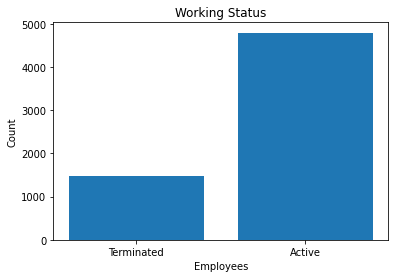

Terminated:  1485
Active:  4799


In [67]:
# Checks Active and Terminated columns because we keep last ones
statusTerminatedCount = len(nonSequentialData[nonSequentialData.STATUS == "TERMINATED"])
statusActiveCount = len(nonSequentialData[nonSequentialData.STATUS == "ACTIVE"])

plt.bar(["Terminated", "Active"],[statusTerminatedCount, statusActiveCount])
plt.xlabel("Employees")
plt.ylabel("Count")
plt.title("Working Status")
plt.show()
print("Terminated: ", statusTerminatedCount)
print("Active: ", statusActiveCount)


<a id="3-3-2-2-drop-unnec"></a>
##### Dropping Unnecassary Features

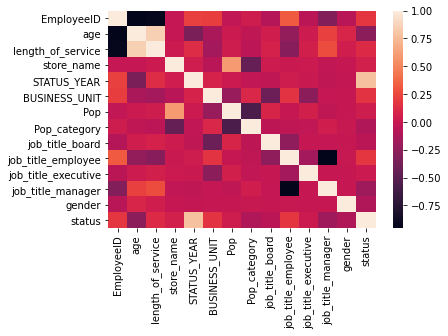

In [68]:
# Correlation Map
sns.heatmap(nonSequentialData.corr())

In [69]:
# Sorted absolute values of correalation matrix
nonSequentialData.corr().abs()['status'].sort_values(ascending=False)

status                 1.000000
STATUS_YEAR            0.782497
age                    0.264318
EmployeeID             0.178260
job_title_employee     0.177928
job_title_manager      0.174992
BUSINESS_UNIT          0.167382
length_of_service      0.121367
Pop_category           0.109118
gender                 0.105256
store_name             0.061885
job_title_board        0.053165
Pop                    0.034909
job_title_executive    0.017197
Name: status, dtype: float64

In [70]:
# Dropping operation
nonSequentialData = nonSequentialData.drop(
    [
     'gender_short', 'gender_full', 'STATUS',
     'city_name', 'EmployeeID', 'recorddate_key',
     'birthdate_key', 'orighiredate_key', 'terminationdate_key',
     'department_name','termreason_desc', 'termtype_desc'
     ], 
     axis=1
)

<a id="3-3-3-seq-prepare"></a>
#### For Sequential Models

In [71]:
# Keeps EmployeeID and recorddate_key
sequentialData = dataset.drop(
    [
     'gender_short', 'gender_full', 'STATUS',
     'city_name',
     'birthdate_key', 'orighiredate_key', 'terminationdate_key',
     'department_name','termreason_desc', 'termtype_desc'
     ], 
     axis=1
)

<a id="4-modelling-and-evaluation"></a>
## Modelling & Evaluation

<a id="4-1-nonseq-models"></a>
### Non Sequential Models

In [72]:
# Seperates labeled value
label = nonSequentialData.status
nonSequentialData = nonSequentialData.drop('status', axis=1)

In [73]:
# Split data as test and train
x_train, x_test, y_train, y_test = train_test_split(nonSequentialData, label, test_size=0.3,
                                                    random_state=10)

In [74]:
def prediction(model, is_svc=False):
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  score = round(accuracy_score(y_test, y_pred), 3)

  cm1 = cm(y_test, y_pred)

  sns.heatmap(cm1, annot=True, fmt=".0f")
  plt.xlabel('Predicted Values')
  plt.ylabel('Actual Values')
  plt.title('Accuracy Score: {0}'.format(score), size = 15)
  plt.show()

  y_proba = None

  if not is_svc:
    y_proba = model.predict_proba(x_test)
  else:
    model = CalibratedClassifierCV(model) 
    model.fit(x_train, y_train)
    y_proba = model.predict_proba(x_test)

  return y_pred, y_proba

<a id="4-1-1-dt"></a>
#### Decision Tree

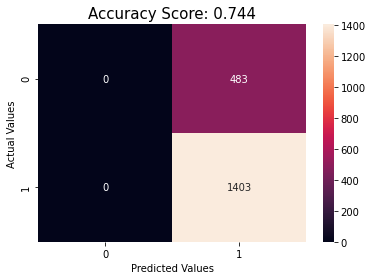

In [75]:
model_dt = tree.DecisionTreeClassifier()
y_pred_dt, y_proba_dt = prediction(model_dt)

<a id="4-1-2-lr"></a>
#### Logistic Regression

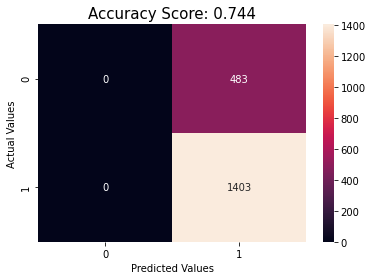

In [76]:
model_lr = LogisticRegression(C=0.001, penalty='l2')
y_pred_lr, y_proba_lr = prediction(model_lr)

<a id="4-1-3-knn"></a>
#### KNN

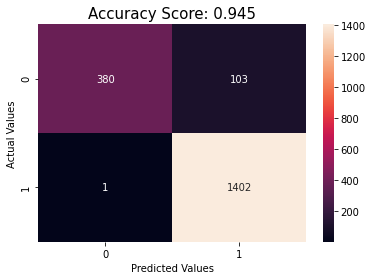

In [77]:
model_knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=14, p=2, weights='distance')
y_pred_knn, y_proba_knn = prediction(model_knn)

<a id="4-1-4-svc"></a>
#### SVC

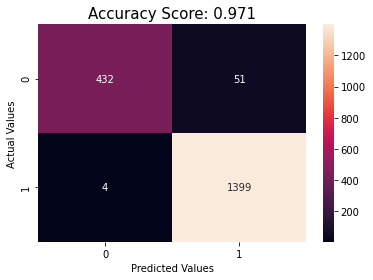

In [78]:
model_svc = SVC(C=10, gamma=0.01, kernel='rbf', random_state=10)
y_pred_svc, y_proba_svc = prediction(model_svc, True)

<a id="4-1-5-rf"></a>
#### Random Forest

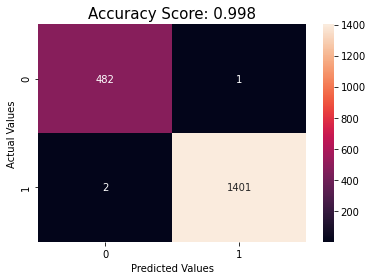

In [79]:
model_rf = RandomForestClassifier(bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=100, random_state=10)
y_pred_rf, y_proba_rf = prediction(model_rf)

<a id="4-1-6-nn"></a>
#### Neural Network

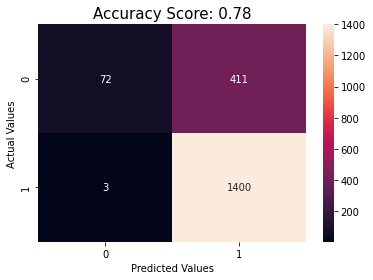

In [80]:
model_mlp = MLPClassifier(alpha=0.05, hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=100)
y_pred_mlp, y_proba_mlp = prediction(model_mlp)

<a id="4-1-7-ensemble"></a>
#### Ensemble Model

In [81]:
# ensemble model

ensemble_proba = (y_proba_dt + y_proba_knn + y_proba_lr + y_proba_svc + y_proba_rf + y_proba_mlp) / 5

y_pred_ens = []

for y in ensemble_proba:
    y_pred = np.where(y == np.amax(y))[0][0]
    y_pred_ens.append(y_pred)

y_pred_ens = np.array(y_pred_ens)

tp = tn = fp = fn = 0

for i, real in enumerate(y_test, start=0):
  pred = y_pred_ens[i]
  if (real == 1 and pred == 1):
    tp += 1
  elif (real == 0 and pred == 0):
    tn += 1
  elif (real == 0 and pred == 1):
    fp += 1
  else:
    fn += 1

precision_1 = tp / (tp + fp)
recall_1 = tp / (tp + fn)
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)

precision_0 = tn / (tn + fn)
recall_0 = tn / (tn + fp)
f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)

for var in ['tp','fp','tn','fn', '', 'precision_1', 'recall_1', 'f1_1', '', 'precision_0', 'recall_0', 'f1_0']:
    if var == '':
      print()
    else:
      print(var + ":         " + str(vars()[var]))

tp:         1403
fp:         109
tn:         374
fn:         0

precision_1:         0.9279100529100529
recall_1:         1.0
f1_1:         0.962607204116638

precision_0:         1.0
recall_0:         0.7743271221532091
f1_0:         0.8728121353558926


<a id="4-1-8-eva"></a>
#### Evaluation

In [82]:
def display_eval_metrics(precision_1, recall_1, f1_1, precision_0, recall_0, f1_0):
  print()
  for var in display_eval_metrics.__code__.co_varnames:
    if var == "precision_0":
      print()
    if var == "var":
      continue
    print(var + ": " + str(vars()[var]))
  print("------------------------------------------------------------------------\n")


def get_eval_metrics(cm):
  tp = cm[1][1]
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]

  precision_1 = tp / (tp + fp)
  recall_1 = tp / (tp + fn)
  f1_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)

  precision_0 = tn / (tn + fn)
  recall_0 = tn / (tn + fp)
  f1_0 = (2 * precision_0 * recall_0) / (precision_0 + recall_0)

  return precision_1, recall_1, f1_1, precision_0, recall_0, f1_0


def draw_roc_curve(predict_obj_list):

  for predict_obj in predict_obj_list:
    model_name = predict_obj[0]
    model_pred = predict_obj[1]

    fpr, tpr, thresholds = roc_curve(y_test.round(0).values.tolist(), model_pred.round(2).tolist(), drop_intermediate=False)
    auc_ = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = model_name + ' ROC curve (AUC = %0.2f)' % auc_);

  plt.legend(loc="lower right")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate');
 

def get_cross_val_eval(model_name, model):

  k = 10
  kf = KFold(n_splits=k, random_state=None)
  
  acc_score = []
  
  X = nonSequentialData
  y = label

  precision_1_list = []
  recall_1_list = []
  f1_1_list = []
  precision_0_list = []
  recall_0_list = []
  f1_0_list = []

  for train_index , test_index in kf.split(X):
      X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
      y_train , y_test = y[train_index] , y[test_index]
      
      model.fit(X_train, y_train)
      
      pred_values = model.predict(X_test)
      
      acc = accuracy_score(pred_values , y_test)
      acc_score.append(acc)
      
      cm1 = cm(y_test, pred_values)

      precision_1, recall_1, f1_1, precision_0, recall_0, f1_0 = get_eval_metrics(cm1)

      precision_1_list.append(precision_1)
      recall_1_list.append(recall_1)
      f1_1_list.append(f1_1)
      precision_0_list.append(precision_0)
      recall_0_list.append(recall_0)
      f1_0_list.append(f1_0)

  print("*** " + model_name + " - average metrics\n")

  avg_acc_score = sum(acc_score)/k
  
  print('Avg accuracy : {}'.format(avg_acc_score))
  display_eval_metrics(mean(precision_1_list), mean(recall_1_list), mean(f1_1_list), mean(precision_0_list), mean(recall_0_list), mean(f1_0_list))  


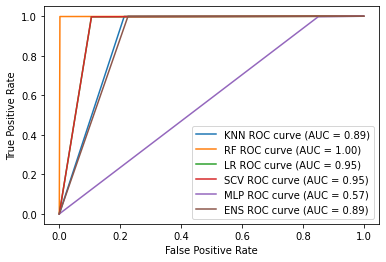

In [83]:
draw_roc_curve([
     ("KNN", y_pred_knn), 
     ("RF", y_pred_rf), 
     ("LR", y_pred_svc), 
     ("SCV", y_pred_svc), 
     ("MLP", y_pred_mlp),
     ("ENS", y_pred_ens)
])

In [84]:
get_cross_val_eval("MLP", model_mlp)
get_cross_val_eval("KNN", model_knn)
get_cross_val_eval("RF", model_rf)
get_cross_val_eval("SVC", model_svc)
get_cross_val_eval("DT", model_dt)
get_cross_val_eval("LR", model_lr)

*** MLP - average metrics

Avg accuracy : 0.7568782720524947

precision_1: nan
recall_1: 0.8984480164460262
f1_1: nan

precision_0: 0.8890691022018544
recall_0: 0.22554484542615455
f1_0: 0.2591793146420037
------------------------------------------------------------------------

*** KNN - average metrics

Avg accuracy : 0.9155063643636142

precision_1: 0.9121564175396015
recall_1: 0.991176848582898
f1_1: 0.9469844810486979

precision_0: 0.9443680794196259
recall_0: 0.657496693630882
f1_0: 0.745869487101064
------------------------------------------------------------------------

*** RF - average metrics

Avg accuracy : 0.9813894261440158

precision_1: 0.9768958274187688
recall_1: 0.99800796812749
f1_1: 0.9866135783507021

precision_0: 0.9913793103448276
recall_0: 0.9467275817302636
f1_0: 0.9661626528042888
------------------------------------------------------------------------

*** SVC - average metrics

Avg accuracy : 0.9565711927738902

precision_1: 0.9551630990855944
recall_1: 0.99

<a id="4-2-seq"></a>
### Sequential Models

<a id="4-2-1-seq-data"></a>
#### Creating Sequential Data Structure

In [85]:
def format_date(raw_date):
    processed_data = parser.parse(str(raw_date))
    return processed_data

date_column = sequentialData.apply(lambda row: format_date(row["recorddate_key"]), axis=1)
sequentialData["recorddate_key"] = date_column

sequentialData = sequentialData.sort_values(['EmployeeID', 'recorddate_key'], ascending=[True, True])

employee_list = sequentialData["EmployeeID"].unique()

structured_data = []
label_list = []

max_len = 0
number_of_features = 6
for employee_id in employee_list:
    employee_frame = sequentialData.loc[sequentialData['EmployeeID'] == employee_id]
    if(employee_frame.shape[0] > max_len):
        max_len = employee_frame.shape[0]

# creating a tensor for each customer
for i, employee_id in enumerate(employee_list, start=0):

    employee_frame = sequentialData.loc[sequentialData['EmployeeID'] == employee_id]
    last_status_value = employee_frame.iloc[[-1]]["status"].values[0]
    employee_frame = employee_frame.drop(columns=['EmployeeID', 'recorddate_key', 'status'])

    tensor = np.zeros((max_len, employee_frame.shape[1]))

    count = 0
    for index, row in employee_frame.iterrows():  
        # padding based on max_len
        tensor[max_len - employee_frame.shape[0] + count] = row.to_numpy()
        count += 1
        
    structured_data.append(tensor)    
    label_list.append(last_status_value)    

structured_data = np.array(structured_data)
label_list = np.array(label_list)

In [86]:
# Splits train test data
train_X, test_X, train_y, test_y = train_test_split(structured_data, label_list, test_size=0.2, random_state=42)

<a id="4-2-2-lstm"></a>
#### LSTM

Epoch 1/30
40/40 - 7s - loss: 0.4607 - accuracy: 0.8035 - val_loss: 0.3828 - val_accuracy: 0.8393
Epoch 2/30
40/40 - 5s - loss: 0.3835 - accuracy: 0.8454 - val_loss: 0.3739 - val_accuracy: 0.8337
Epoch 3/30
40/40 - 5s - loss: 0.3597 - accuracy: 0.8494 - val_loss: 0.3722 - val_accuracy: 0.8369
Epoch 4/30
40/40 - 5s - loss: 0.3476 - accuracy: 0.8494 - val_loss: 0.3609 - val_accuracy: 0.8401
Epoch 5/30
40/40 - 5s - loss: 0.3369 - accuracy: 0.8516 - val_loss: 0.3603 - val_accuracy: 0.8353
Epoch 6/30
40/40 - 5s - loss: 0.3330 - accuracy: 0.8522 - val_loss: 0.3455 - val_accuracy: 0.8401
Epoch 7/30
40/40 - 5s - loss: 0.3305 - accuracy: 0.8528 - val_loss: 0.3647 - val_accuracy: 0.8178
Epoch 8/30
40/40 - 5s - loss: 0.3270 - accuracy: 0.8494 - val_loss: 0.3463 - val_accuracy: 0.8433
Epoch 9/30
40/40 - 5s - loss: 0.3199 - accuracy: 0.8544 - val_loss: 0.3636 - val_accuracy: 0.7908
Epoch 10/30
40/40 - 5s - loss: 0.3182 - accuracy: 0.8574 - val_loss: 0.3451 - val_accuracy: 0.8457
Epoch 11/30
40/40 -

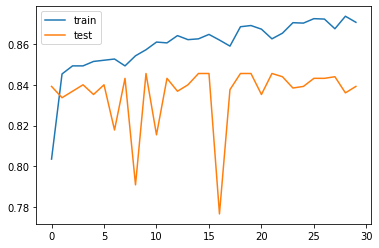

In [87]:
model_lstm = Sequential()
model_lstm.add(LSTM(250, dropout=0.2, recurrent_dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2])))

model_lstm.add(Dense(250, activation='relu'))
model_lstm.add(Dense(2, activation='softmax')) #2 -> number of labels
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
early_stop = EarlyStopping(monitor="val_loss", verbose=2, mode='min', patience=3)
history = model_lstm.fit(train_X, train_y, epochs=30, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=True)

# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

<a id="4-2-3-gru"></a>
#### GRU

Epoch 1/30
79/79 - 8s - loss: 0.4298 - accuracy: 0.8186 - val_loss: 0.4561 - val_accuracy: 0.8369
Epoch 2/30
79/79 - 6s - loss: 0.3925 - accuracy: 0.8391 - val_loss: 0.3643 - val_accuracy: 0.8393
Epoch 3/30
79/79 - 6s - loss: 0.3596 - accuracy: 0.8403 - val_loss: 0.3701 - val_accuracy: 0.8465
Epoch 4/30
79/79 - 6s - loss: 0.3499 - accuracy: 0.8478 - val_loss: 0.3548 - val_accuracy: 0.8433
Epoch 5/30
79/79 - 6s - loss: 0.3495 - accuracy: 0.8450 - val_loss: 0.3689 - val_accuracy: 0.8433
Epoch 6/30
79/79 - 6s - loss: 0.3214 - accuracy: 0.8542 - val_loss: 0.3332 - val_accuracy: 0.8441
Epoch 7/30
79/79 - 6s - loss: 0.3238 - accuracy: 0.8500 - val_loss: 0.3371 - val_accuracy: 0.8457
Epoch 8/30
79/79 - 6s - loss: 0.3139 - accuracy: 0.8534 - val_loss: 0.3388 - val_accuracy: 0.8369
Epoch 9/30
79/79 - 6s - loss: 0.3088 - accuracy: 0.8530 - val_loss: 0.3442 - val_accuracy: 0.8441
Epoch 10/30
79/79 - 6s - loss: 0.3014 - accuracy: 0.8627 - val_loss: 0.3367 - val_accuracy: 0.8425
Epoch 11/30
79/79 -

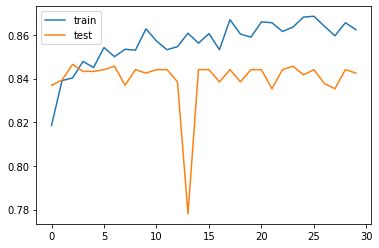

In [88]:
model_gru = Sequential()
model_gru.add(GRU(250, dropout=0.2, recurrent_dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2])))

model_gru.add(Dense(250, activation='tanh'))
model_gru.add(Dense(2, activation='softmax')) #2 -> number of labels
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
early_stop=EarlyStopping(monitor="val_accuracy",verbose=2,mode='max',patience=3)
history = model_gru.fit(train_X, train_y, epochs=30, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=True)

# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

<a id="4-2-4-ensemble"></a>
#### Ensemble Model

In [89]:
yhat_lstm = model_lstm.predict(test_X, verbose=0)
yhat_gru = model_gru.predict(test_X, verbose=0)

yhat_ens = (yhat_gru + yhat_lstm) / 2

<a id="4-2-5-evaluation"></a>
#### Evaluation

In [90]:
def evaluate_sequential_model(model_name, predictions, real_values):

  test_X_predictions = []

  for y in predictions:
      y = np.round(y, decimals=3)
      y_pred = np.where(y == np.amax(y))[0][0]
      test_X_predictions.append(y_pred)

  tp = tn = fp = fn = 0

  for i, real in enumerate(real_values, start=0):
    pred = test_X_predictions[i]
    if (real == 1 and pred == 1):
      tp += 1
    elif (real == 0 and pred == 0):
      tn += 1
    elif (real == 0 and pred == 1):
      fp += 1
    else:
      fn += 1


  precision_1 = tp / (tp + fp)
  recall_1 = tp / (tp + fn)
  f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)

  precision_0 = tn / (tn + fn)
  recall_0 = tn / (tn + fp)
  f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)

  print(model_name)  
  print("---")

  for var in ['tp','fp','tn','fn', '', 'precision_1', 'recall_1', 'f1_1', '', 'precision_0', 'recall_0', 'f1_0']:
    if var == '':
      print()
    else:
      print(var + ":         " + str(vars()[var]))

  print("-----------------------------------\n")

In [91]:
evaluate_sequential_model("LSTM", yhat_lstm, test_y)
evaluate_sequential_model("GRU", yhat_gru, test_y)
evaluate_sequential_model("ENS", yhat_ens, test_y)

LSTM
---
tp:         876
fp:         125
tn:         179
fn:         77

precision_1:         0.8751248751248751
recall_1:         0.919202518363064
f1_1:         0.8966223132036848

precision_0:         0.69921875
recall_0:         0.5888157894736842
f1_0:         0.6392857142857143
-----------------------------------

GRU
---
tp:         922
fp:         167
tn:         137
fn:         31

precision_1:         0.8466483011937558
recall_1:         0.9674711437565582
f1_1:         0.9030362389813908

precision_0:         0.8154761904761905
recall_0:         0.4506578947368421
f1_0:         0.5805084745762712
-----------------------------------

ENS
---
tp:         922
fp:         167
tn:         137
fn:         31

precision_1:         0.8466483011937558
recall_1:         0.9674711437565582
f1_1:         0.9030362389813908

precision_0:         0.8154761904761905
recall_0:         0.4506578947368421
f1_0:         0.5805084745762712
-----------------------------------

